### Credit Card Lead Prediction

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

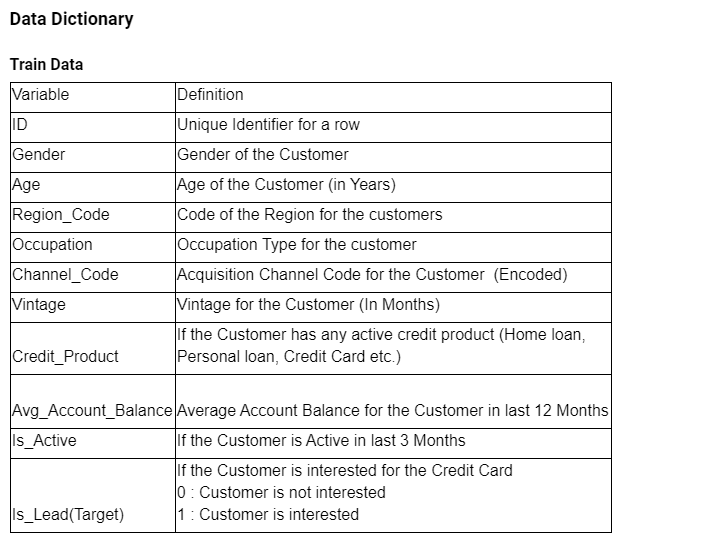
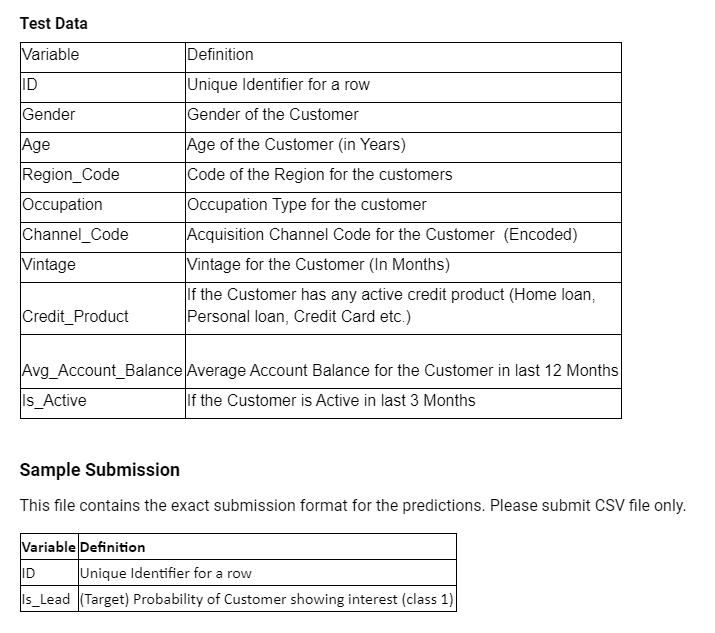

In [75]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style(style= 'darkgrid')
import missingno

# Let's ignore warnings
import warnings
warnings.filterwarnings('ignore')


# pre-processing method
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# the regression models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
import lightgbm as lgb

# methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import time

In [2]:
train_Data = pd.read_csv('train_s3TEQDk.csv')
test_Data = pd.read_csv('test_mSzZ8RL.csv')
sample_Submission = pd.read_csv('sample_submission_eyYijxG.csv') # example of what a submission should look like

In [3]:
# View the training data
train_Data.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

In [4]:
# View the test data
test_Data.head()

ID  Gender  Age Region_Code Occupation Channel_Code  Vintage  \
0  VBENBARO    Male   29       RG254      Other           X1       25   
1  CCMEWNKY    Male   43       RG268      Other           X2       49   
2  VK3KGA9M    Male   31       RG270   Salaried           X1       14   
3  TT8RPZVC    Male   29       RG272      Other           X1       33   
4  SHQZEYTZ  Female   29       RG270      Other           X1       19   

  Credit_Product  Avg_Account_Balance Is_Active  
0            Yes               742366        No  
1            NaN               925537        No  
2             No               215949        No  
3             No               868070        No  
4             No               657087        No

In [5]:
#Storing ID values for the final use
ID = test_Data['ID']
ID

0         VBENBARO
1         CCMEWNKY
2         VK3KGA9M
3         TT8RPZVC
4         SHQZEYTZ
            ...   
105307    DBENJOYI
105308    CWQ72DWS
105309    HDESC8GU
105310    2PW4SFCA
105311    F2NOYPPZ
Name: ID, Length: 105312, dtype: object

In [6]:
# View the sample submission data
sample_Submission.head()

ID  Is_Lead
0  VBENBARO        0
1  CCMEWNKY        0
2  VK3KGA9M        0
3  TT8RPZVC        0
4  SHQZEYTZ        0

In [7]:
#shape and size of the datasets
tr_row,tr_col = train_Data.shape
ts_row,ts_col = test_Data.shape
print('Train dataset is having rows:',tr_row,', columns:',tr_col ,'and size :',train_Data.size)
print('Test dataset is having rows:',ts_row,', columns:',ts_col ,'and size :',test_Data.size)

Train dataset is having rows: 245725 , columns: 11 and size : 2702975
Test dataset is having rows: 105312 , columns: 10 and size : 1053120


In [8]:
train_Data.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

# EDA

In [9]:
train_Data.describe().T

count          mean            std      min       25%  \
Age                  245725.0  4.385631e+01      14.828672     23.0      30.0   
Vintage              245725.0  4.695914e+01      32.353136      7.0      20.0   
Avg_Account_Balance  245725.0  1.128403e+06  852936.356069  20790.0  604310.0   
Is_Lead              245725.0  2.372083e-01       0.425372      0.0       0.0   

                          50%        75%         max  
Age                      43.0       54.0        85.0  
Vintage                  32.0       73.0       135.0  
Avg_Account_Balance  894601.0  1366666.0  10352009.0  
Is_Lead                   0.0        0.0         1.0

In [10]:
train_Data.describe(include=object).T

count  unique            top    freq
ID              245725  245725       3XTIKIGY       1
Gender          245725       2           Male  134197
Region_Code     245725      35          RG268   35934
Occupation      245725       4  Self_Employed  100886
Channel_Code    245725       4             X1  103718
Credit_Product  216400       2             No  144357
Is_Active       245725       2             No  150290

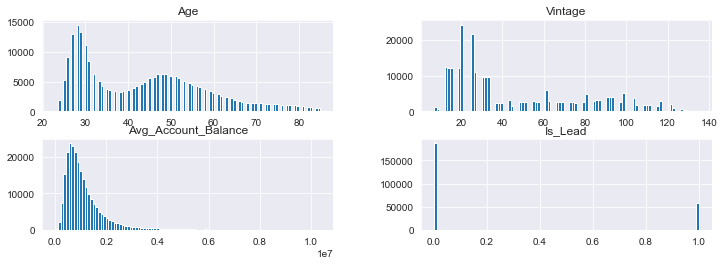

In [11]:
columns = list(train_Data) 
train_Data[columns].hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

In [12]:
print('Age: Most of the customers ages in between 25 to 30 and 45 to 55')
print('Vintage: Maximum customer are in relation with back are below 35 months')
print('Avg_Account_Balance: Average Account Balance for the maximum Customers is less than 2 millions ')

Age: Most of the customers ages in between 25 to 30 and 45 to 55
Vintage: Maximum customer are in relation with back are below 35 months
Avg_Account_Balance: Average Account Balance for the maximum Customers is less than 2 millions 


<AxesSubplot:>

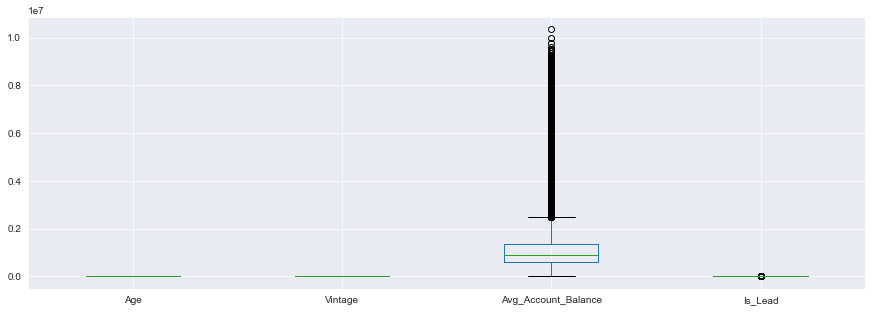

In [13]:
train_Data.boxplot(figsize=(15,5))

In [14]:
print('Avg_Account_Balance is right skewed')

Avg_Account_Balance is right skewed


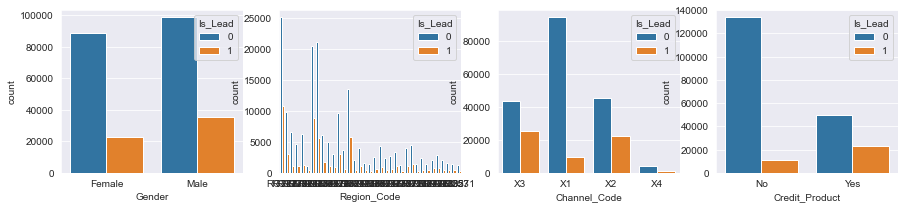

In [15]:
count=1
list=['Gender', 'Region_Code', 'Channel_Code', 'Credit_Product']
plt.subplots(figsize=(15, 3))
for col in list:
    plt.subplot(1,4,count)
    sns.countplot(x=train_Data[col],hue=train_Data.Is_Lead)
    count+=1

plt.show()

In [16]:
#Find if any null values in train dataset
train_Data.isnull().any()

ID                     False
Gender                 False
Age                    False
Region_Code            False
Occupation             False
Channel_Code           False
Vintage                False
Credit_Product          True
Avg_Account_Balance    False
Is_Active              False
Is_Lead                False
dtype: bool

In [17]:
#Find if any null values in test dataset
test_Data.isnull().any()

ID                     False
Gender                 False
Age                    False
Region_Code            False
Occupation             False
Channel_Code           False
Vintage                False
Credit_Product          True
Avg_Account_Balance    False
Is_Active              False
dtype: bool

<AxesSubplot:>

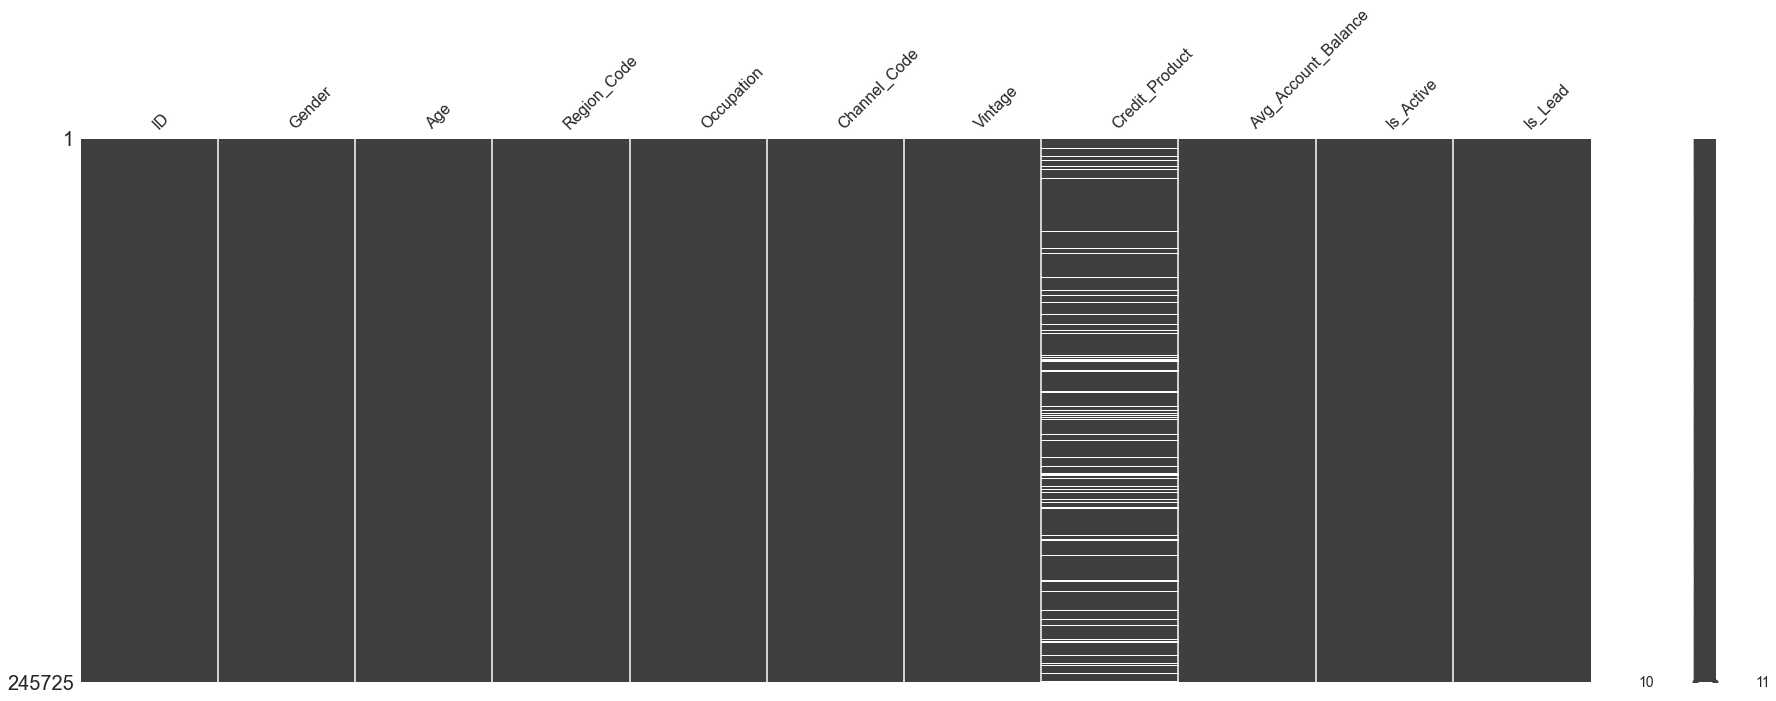

In [18]:
# Plot graphic for missing values
missingno.matrix(train_Data, figsize = (30,10))

In [19]:
print('From the above, we can understand that missing values are present only in feature - CreditProduct')

From the above, we can understand that missing values are present only in feature - CreditProduct


In [20]:
train_Data['Credit_Product'].unique()

array(['No', nan, 'Yes'], dtype=object)

Drop vs Impute missing data

In [21]:
actual_size = train_Data.size
drop_size = train_Data[(train_Data['Credit_Product'] == 'No') | (train_Data['Credit_Product'] == 'Yes')].size

In [22]:
print("Actual table size", actual_size,"vs","Drop_NaN :",drop_size)
# Data drop impact analysis

Data_lost=((actual_size-drop_size)/actual_size)*100
print("Percentage of data lost by dropping NaN :",Data_lost,"%")
if Data_lost<=5:
    print("\n==> Not much data has been lost,dropping data was a good option")
else:
    print("\n==> Considerable data has been lost,dropping data was not a good option. We can consider to impute missing data")

Actual table size 2702975 vs Drop_NaN : 2380400
Percentage of data lost by dropping NaN : 11.9340726421813 %

==> Considerable data has been lost,dropping data was not a good option. We can consider to impute missing data


In [23]:
full_Data = [train_Data, test_Data]
full_Data

[              ID  Gender  Age Region_Code     Occupation Channel_Code  \
 0       NNVBBKZB  Female   73       RG268          Other           X3   
 1       IDD62UNG  Female   30       RG277       Salaried           X1   
 2       HD3DSEMC  Female   56       RG268  Self_Employed           X3   
 3       BF3NC7KV    Male   34       RG270       Salaried           X1   
 4       TEASRWXV  Female   30       RG282       Salaried           X1   
 ...          ...     ...  ...         ...            ...          ...   
 245720  BPAWWXZN    Male   51       RG284  Self_Employed           X3   
 245721  HFNB7JY8    Male   27       RG268       Salaried           X1   
 245722  GEHAUCWT  Female   26       RG281       Salaried           X1   
 245723  GE7V8SAH  Female   28       RG273       Salaried           X1   
 245724  BOCZSWLJ    Male   29       RG269       Salaried           X1   
 
         Vintage Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
 0            43             No     

In [24]:
# Remove all NULLS in the Embarked column
for dataset in full_Data:
    dataset['Credit_Product'] = dataset['Credit_Product'].fillna("Unknown")

In [25]:
for dataset in full_Data:
# Mapping 'Credit_Product'
    dataset['Credit_Product'] = dataset['Credit_Product'].map( {'Yes': 0, 'No': 1, 'Unknown': 2} ).astype(int)
# Mapping 'Gender'
    dataset['Gender'] = dataset['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
# Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
# Mapping Channel_Code
    dataset['Channel_Code'] = dataset['Channel_Code'].map( {'X1': 1, 'X2': 2, 'X3': 3, 'X4': 4} ).astype(int)
# Mapping Vintage
    dataset.loc[ dataset['Vintage'] <= 24, 'Vintage'] 					       = 0
    dataset.loc[(dataset['Vintage'] > 24) & (dataset['Vintage'] <= 28), 'Vintage'] = 1
    dataset.loc[(dataset['Vintage'] > 48) & (dataset['Vintage'] <= 72), 'Vintage'] = 2
    dataset.loc[(dataset['Vintage'] > 72) & (dataset['Vintage'] <= 96), 'Vintage'] = 3
    dataset.loc[ dataset['Vintage'] > 120, 'Vintage'] = 4 ;
#Mapping Occupation
    dataset['Occupation'] = dataset['Occupation'].map( {'Other': 0, 'Salaried': 1, 'Self_Employed': 2, 'Entrepreneur':3 } ).astype(int)
#MApping Is_Active
    dataset['Is_Active'] = dataset['Is_Active'].map( {'Yes': 0, 'No': 1} ).astype(int)

In [26]:
le = LabelEncoder()
for dataset in full_Data:
# Mapping 'Region_Code'
    dataset['Region_Code'] = le.fit_transform(dataset['Region_Code'])

In [27]:
full_Data

[              ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
 0       NNVBBKZB       0    4           18           0             3       43   
 1       IDD62UNG       0    1           27           1             1       32   
 2       HD3DSEMC       0    3           18           2             3        1   
 3       BF3NC7KV       1    2           20           1             1        0   
 4       TEASRWXV       0    1           32           1             1       33   
 ...          ...     ...  ...          ...         ...           ...      ...   
 245720  BPAWWXZN       1    3           34           2             3      109   
 245721  HFNB7JY8       1    1           18           1             1        0   
 245722  GEHAUCWT       0    1           31           1             1        0   
 245723  GE7V8SAH       0    1           23           1             1       31   
 245724  BOCZSWLJ       1    1           19           1             1        0   
 
         Credi

In [28]:
train_Data.head()

ID  Gender  Age  Region_Code  Occupation  Channel_Code  Vintage  \
0  NNVBBKZB       0    4           18           0             3       43   
1  IDD62UNG       0    1           27           1             1       32   
2  HD3DSEMC       0    3           18           2             3        1   
3  BF3NC7KV       1    2           20           1             1        0   
4  TEASRWXV       0    1           32           1             1       33   

   Credit_Product  Avg_Account_Balance  Is_Active  Is_Lead  
0               1              1045696          1        0  
1               1               581988          1        0  
2               1              1484315          0        0  
3               1               470454          1        0  
4               1               886787          1        0

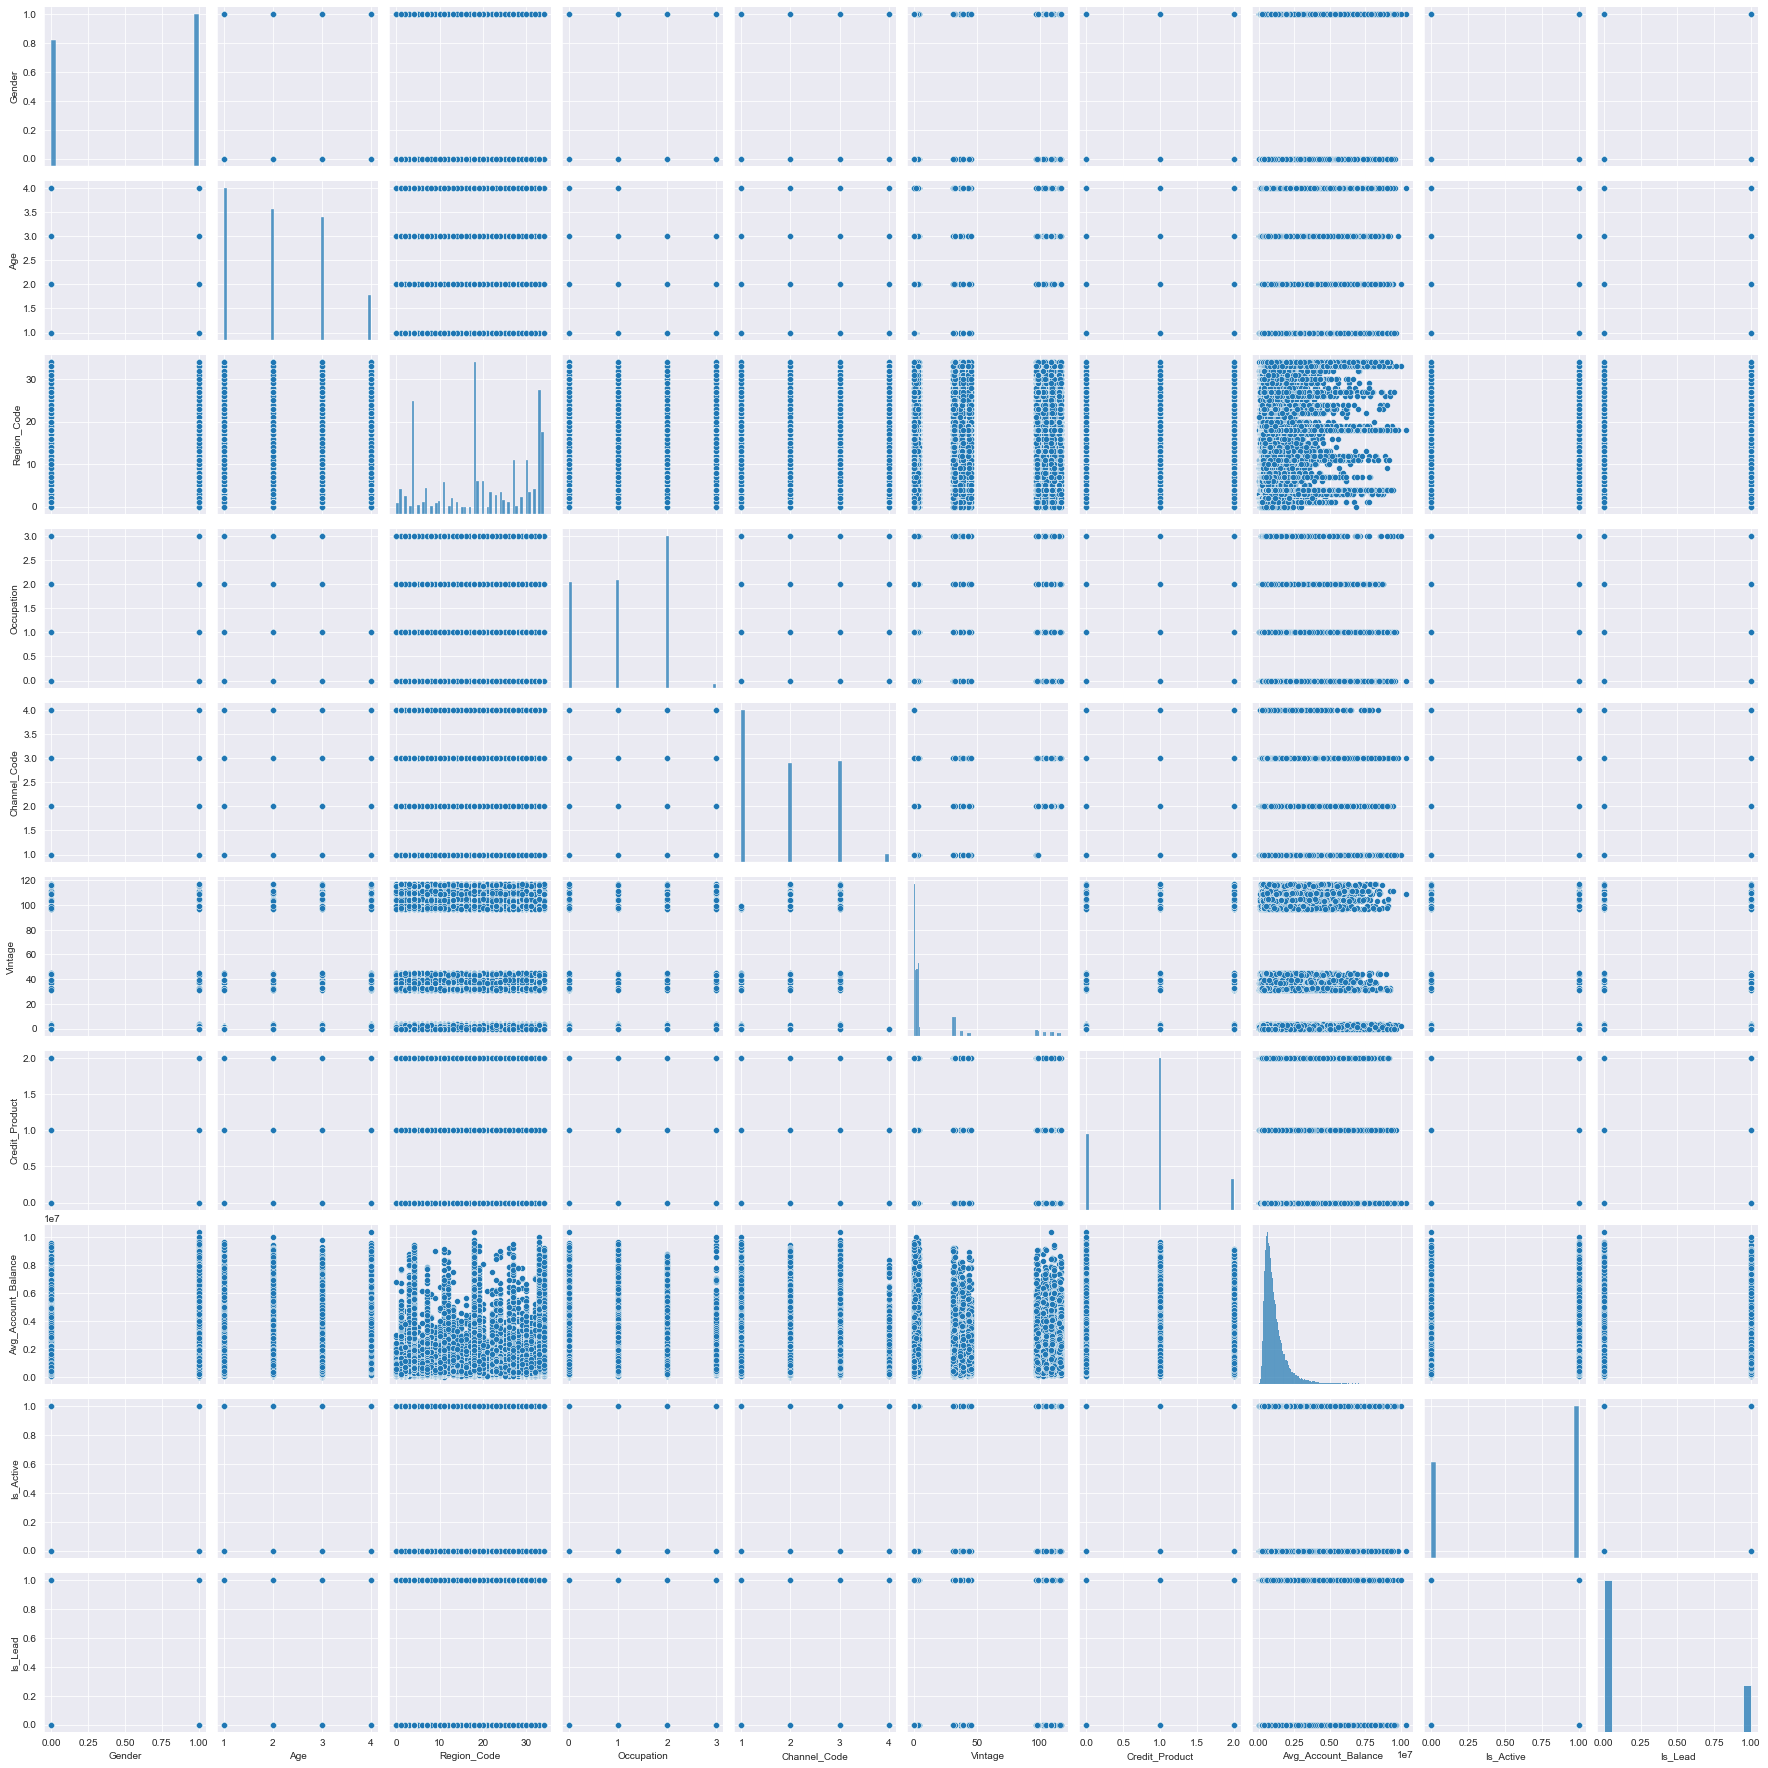

In [29]:
sns.pairplot(train_Data)

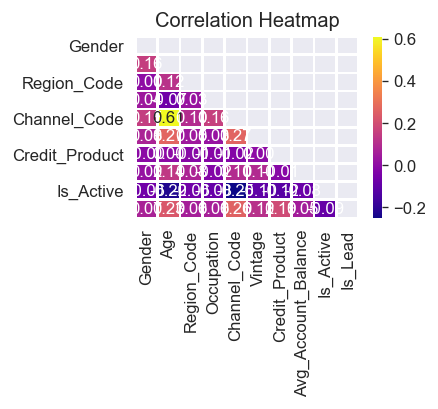

In [30]:
sns.set_style('darkgrid')
plt.figure(dpi = 120,figsize= (3,2))
mask = np.triu(np.ones_like(train_Data.corr(),dtype = bool))
sns.heatmap(train_Data.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

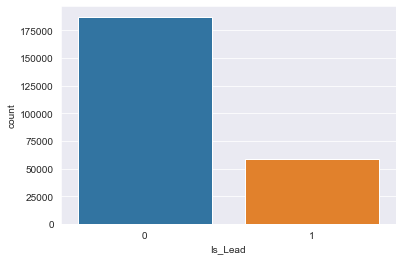

In [31]:
sns.countplot(x=train_Data['Is_Lead'])

In [32]:
# Split the dataframe into data and labels
X = train_Data.drop(['ID','Is_Lead'], axis=1) #data
y = train_Data['Is_Lead'] #labels
test = test_Data.drop(['ID'], axis=1) #data

In [33]:
#split data into Train set and Validation set
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.25, random_state = 2021)
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_valid shape: ', x_valid.shape)
print('y_valid shape: ', y_valid.shape)

x_train shape:  (184293, 9)
y_train shape:  (184293,)
x_valid shape:  (61432, 9)
y_valid shape:  (61432,)


In [34]:
#Verifying the train validation split
print("{0:0.2f}% data is in Train set".format((len(x_train)/len(train_Data.index)) * 100))
print("{0:0.2f}% data is in Validation set".format((len(x_valid)/len(train_Data.index)) * 100))

75.00% data is in Train set
25.00% data is in Validation set


In [35]:
print("Original Is_Lead True Values    : {0} ({1:0.2f}%)".format(len(train_Data.loc[train_Data['Is_Lead'] == 1]), (len(train_Data.loc[train_Data['Is_Lead'] == 1])/len(train_Data.index)) * 100))
print("Original Is_Lead False Values   : {0} ({1:0.2f}%)".format(len(train_Data.loc[train_Data['Is_Lead'] == 0]), (len(train_Data.loc[train_Data['Is_Lead'] == 0])/len(train_Data.index)) * 100))
print("")
print("Training Is_Lead True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Is_Lead False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Valid Is_Lead True Values        : {0} ({1:0.2f}%)".format(len(y_valid[y_valid[:] == 1]), (len(y_valid[y_valid[:] == 1])/len(y_valid)) * 100))
print("Valid Is_Lead False Values       : {0} ({1:0.2f}%)".format(len(y_valid[y_valid[:] == 0]), (len(y_valid[y_valid[:] == 0])/len(y_valid)) * 100))
print("")

Original Is_Lead True Values    : 58288 (23.72%)
Original Is_Lead False Values   : 187437 (76.28%)

Training Is_Lead True Values    : 43809 (23.77%)
Training Is_Lead False Values   : 140484 (76.23%)

Valid Is_Lead True Values        : 14479 (23.57%)
Valid Is_Lead False Values       : 46953 (76.43%)



In [36]:
#define a function to plot confusion matrix
def confusion_matrix_plot(x_train,y_train,x_valid,y_valid,classifier,y_pred,classifier_name):
    fig,ax = plt.subplots(figsize=(7,6))
    plot_confusion_matrix(classifier,x_valid,y_valid,display_labels=["Not Interested","Interested"],normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - confusion matrix')
    plt.show()
    global acc_train_sc, acc_valid_sc
    acc_train_sc = round(classifier.score(x_train,y_train)*100,2)
    acc_valid_sc = round(accuracy_score(y_valid,y_pred)*100,2)
    print(f'Accuracy Score Valid: {acc_valid_sc}')
    print(f'Accuracy Score Train: {acc_train_sc}')
    return print("")

In [37]:
#define a function to plot ROC curve and AUC score
def roc_curve_auc_score(x_valid,y_valid,y_pred_prob,classifier_name):
    y_pred_proba = y_pred_prob[:,1]
    fpr, tpr, thresholds = roc_curve(y_valid,y_pred_proba)
    
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel("false positive Rate")
    plt.ylabel("True positive Rate")
    plt.title(f'{classifier_name} - ROC curve')
    plt.show()
    global score
    score = round(roc_auc_score(y_valid, y_pred_proba)*100,2)
    return print(f'AUC SCore (ROC): {score} \n')

In [38]:
#define a function to plot precision recall curve and F1 score and AUC score

def precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob,classifier_name):
    y_pred_proba = y_pred_prob[:,1]
    precision, recall, thresholds = precision_recall_curve(y_valid,y_pred_proba)
    
    plt.plot(recall, precision, label=f'{classifier_name}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f'{classifier_name} - Precision Recall curve')
    plt.show()
    global f1_score_result,auc_score_result
    f1_score_result = round(f1_score(y_valid, y_pred)*100,2)
    auc_score_result = round(auc(recall, precision)*100,2)
    #f1_score_result, auc_score_result = f1_score(y_valid, y_pred), auc(recall, precision)
    
    return print(f'F1 score: {f1_score_result} \nAUC Score (PR): {auc_score_result}\n')
    

# Decision Tree Model:

In [41]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [42]:
#scoring decision Tree
dTree_acc_train_sc = round(dTree.score(x_train, y_train)*100,2)
dTree_acc_valid_sc = round(dTree.score(x_valid, y_valid)*100,2)

print('accuracy score of decision tree Train set is', dTree_acc_train_sc)
print('accuracy score of decision tree Valid set is', dTree_acc_valid_sc)

accuracy score of decision tree Train set is 99.98
accuracy score of decision tree Valid set is 78.46


In [43]:
#Training set score is almost about to 1 where as Test set score is about 72.7%
#Reducing Overfitting

dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR.fit(x_train, y_train)

dTreeR_acc_train_sc = round(dTreeR.score(x_train, y_train)*100,2)
dTreeR_acc_valid_sc = round(dTreeR.score(x_valid, y_valid)*100,2)
print('accuracy score of Pruned decision tree Train set is', dTreeR_acc_train_sc)
print('accuracy score of Pruned decision tree Valid  set is', dTreeR_acc_valid_sc)

accuracy score of Pruned decision tree Train set is 84.65
accuracy score of Pruned decision tree Valid  set is 84.74


In [44]:
print('with pruning by including max_depth=3, Got trainig score of 84.65 and Testing score of 84.74')

with pruning by including max_depth=3, Got trainig score of 84.65 and Testing score of 84.74


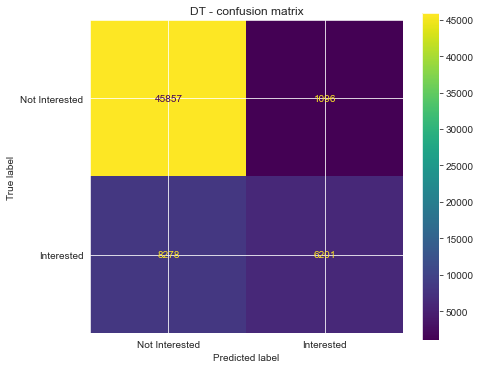

Accuracy Score Valid: 84.74
Accuracy Score Train: 84.65



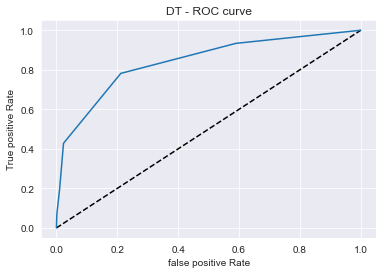

AUC SCore (ROC): 84.01 



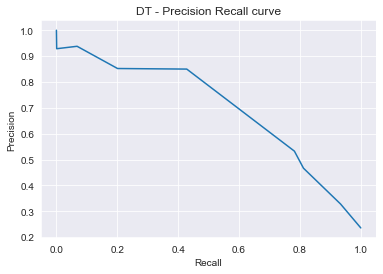

F1 score: 56.95 
AUC Score (PR): 70.24



In [45]:
y_pred = dTreeR.predict(x_valid)
y_pred_prob = dTreeR.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, dTreeR, y_pred, 'DT')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'DT')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'DT')

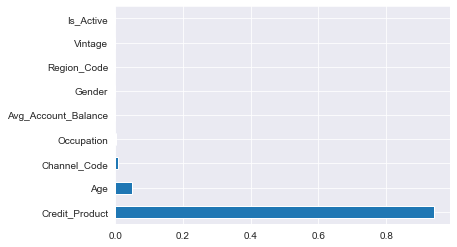

In [46]:
#Importance of features in the training dataset
feat_importances = pd.Series(dTreeR.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [47]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = resultsDf[['Method', 'Train accuracy','Valid accuracy','ROC AUC Score','F1 Score', 'PR AUC_Score']]
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  F1 Score  \
0  Decision Tree           84.65           84.74          84.01     56.95   

   PR AUC_Score  
0         70.24

In [48]:
#Predit the test set for Is_Lead values
dTreeR_pred= dTreeR.predict_proba(test)[:, 1]
print('dTreeR_pred :', dTreeR_pred)
Is_Lead_values = dTreeR_pred.round()
print('Is_Lead_values :', Is_Lead_values)

dTreeR_pred : [0.11679198 0.83998851 0.04753044 ... 0.10508743 0.10508743 0.04753044]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [49]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': dTreeR_pred })
Final_Submission.to_csv("dTreeR.csv", index = False)

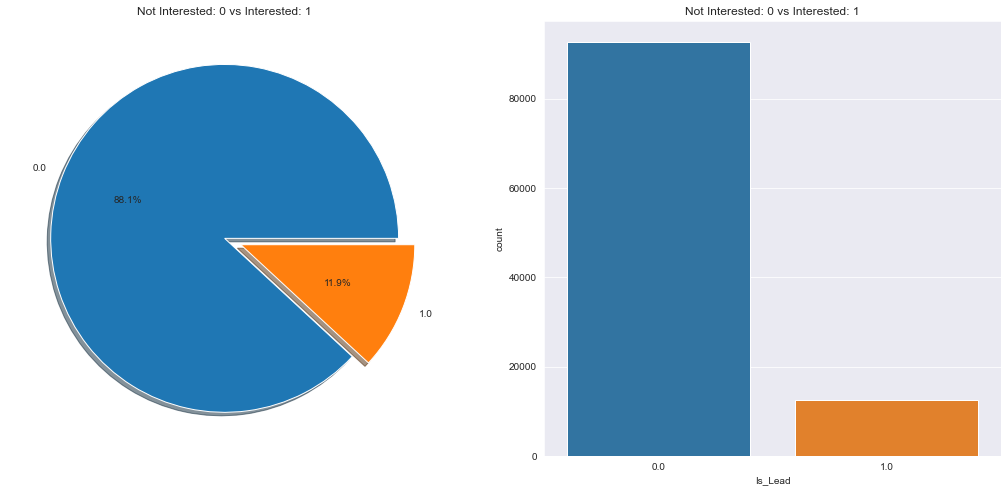

In [50]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values })
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()

# Random Forest Tree:

In [51]:
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(x_train, y_train)

#scoring decision Tree
rfcl_acc_train_sc = round(rfcl.score(x_train, y_train)*100,2)
rfcl_acc_valid_sc = round(rfcl.score(x_valid, y_valid)*100,2)
print('accuracy score of Random Forest tree Train set is', rfcl_acc_train_sc)
print('accuracy score of Random Forest tree Valid set is', rfcl_acc_valid_sc)

accuracy score of Random Forest tree Train set is 99.86
accuracy score of Random Forest tree Valid set is 83.11


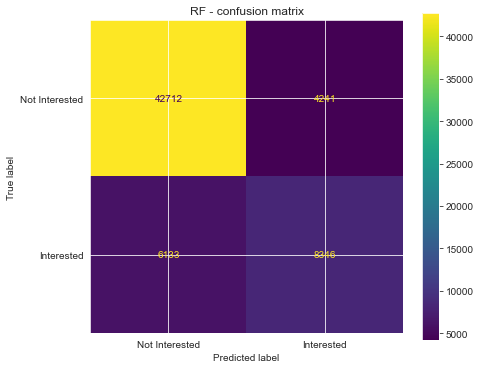

Accuracy Score Valid: 83.11
Accuracy Score Train: 99.86



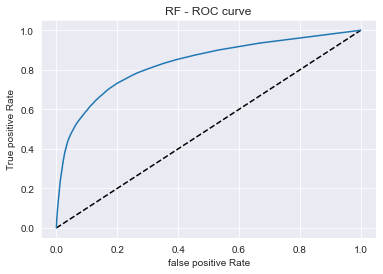

AUC SCore (ROC): 83.25 



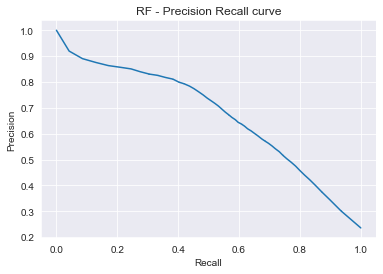

F1 score: 61.67 
AUC Score (PR): 67.23



In [52]:
y_pred = rfcl.predict(x_valid)
y_pred_prob = rfcl.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, rfcl, y_pred, 'RF')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'RF')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'RF')

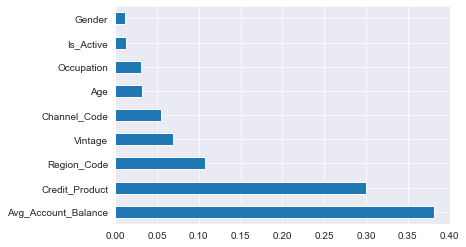

In [53]:
#Importance of features in the training dataset
feat_importances = pd.Series(rfcl.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [54]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Random Forest Tree'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23

In [55]:
print('Comparatively Decision Tree has better accuracy than random Forest')

Comparatively Decision Tree has better accuracy than random Forest


# Adaboost Ensemble Algorithm

In [56]:
abcl = AdaBoostClassifier( n_estimators= 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(x_train, y_train)

abcl_acc_train_sc = round(abcl.score(x_train, y_train)*100,2)
abcl_acc_valid_sc = round(abcl.score(x_valid, y_valid)*100,2)
print('accuracy score of AdaBoost Train set is', abcl_acc_train_sc)
print('accuracy score of AdaBoost Valid set is', abcl_acc_valid_sc)

accuracy score of AdaBoost Train set is 84.65
accuracy score of AdaBoost Valid set is 84.74


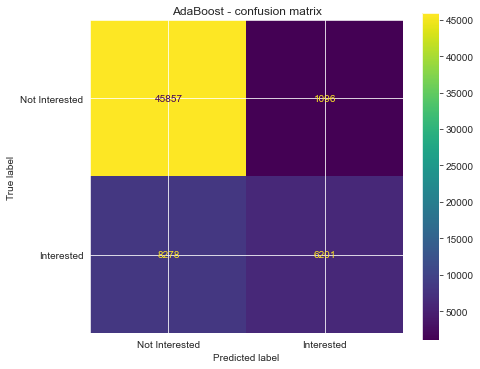

Accuracy Score Valid: 84.74
Accuracy Score Train: 84.65



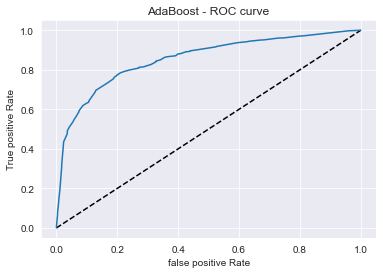

AUC SCore (ROC): 85.41 



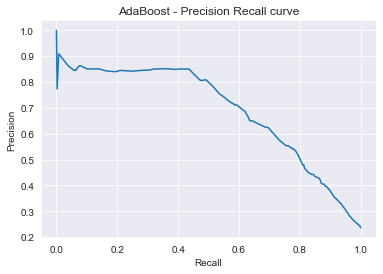

F1 score: 56.95 
AUC Score (PR): 69.33



In [57]:
y_pred = abcl.predict(x_valid)
y_pred_prob = abcl.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, abcl, y_pred, 'AdaBoost')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'AdaBoost')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'AdaBoost')

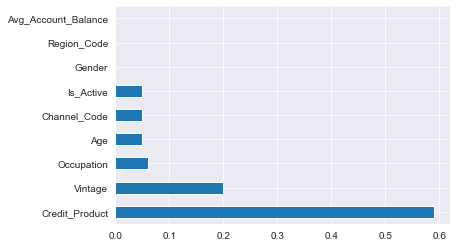

In [58]:
#Importance of features in the training dataset
feat_importances = pd.Series(abcl.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [59]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['AdaBoost'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33

In [60]:
print('Comparatively AdaBoost has better ROC AUC score than Decision Tree')

Comparatively AdaBoost has better ROC AUC score than Decision Tree


In [61]:
#Predit the test set for Is_Lead values
abcl_pred = abcl.predict_proba(test)[:, 1]
print('abcl_pred :', abcl_pred)
Is_Lead_values = abcl_pred.round()
print('Is_Lead_values :', Is_Lead_values)

abcl_pred : [0.45625273 0.53456506 0.42423999 ... 0.44585617 0.45555601 0.42423999]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [62]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': abcl_pred })
Final_Submission.to_csv("AdaBoost.csv", index = False)

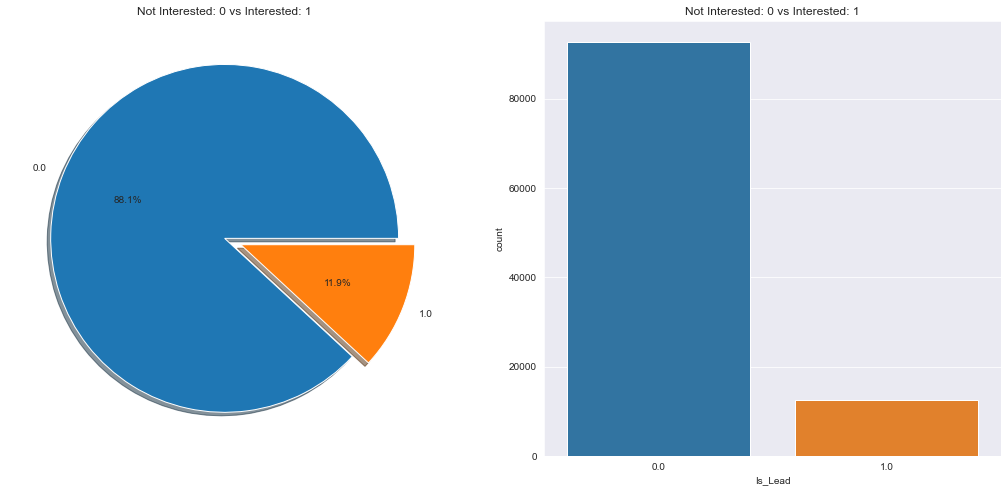

In [63]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values})
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()



# GradientBoost Classifier Algorithm

In [66]:
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(x_train, y_train)

gbcl_acc_train_sc = round(gbcl.score(x_train, y_train)*100,2)
gbcl_acc_valid_sc = round(gbcl.score(x_valid, y_valid)*100,2)
print('accuracy score of GradientBoost Train set is', gbcl_acc_train_sc)
print('accuracy score of GradientBoost Valid set is', gbcl_acc_valid_sc)

accuracy score of GradientBoost Train set is 85.46
accuracy score of GradientBoost Valid set is 85.47


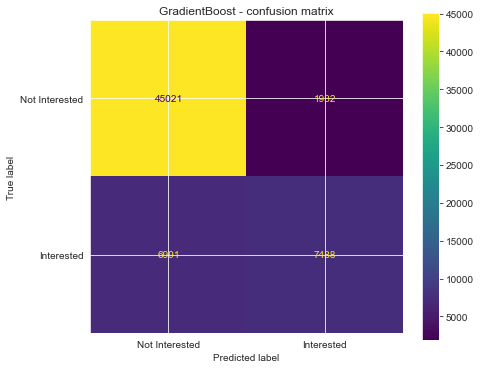

Accuracy Score Valid: 85.47
Accuracy Score Train: 85.46



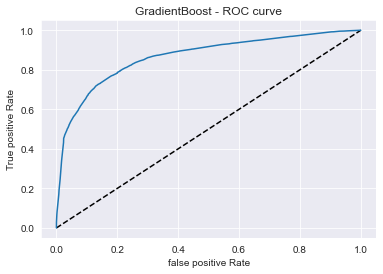

AUC SCore (ROC): 86.57 



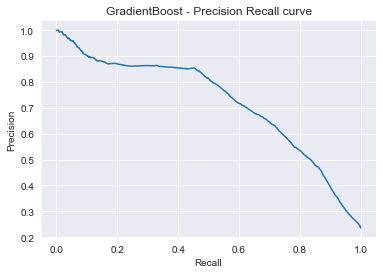

F1 score: 62.66 
AUC Score (PR): 72.27



In [67]:
y_pred = gbcl.predict(x_valid)
y_pred_prob = gbcl.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, gbcl, y_pred, 'GradientBoost')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'GradientBoost')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'GradientBoost')

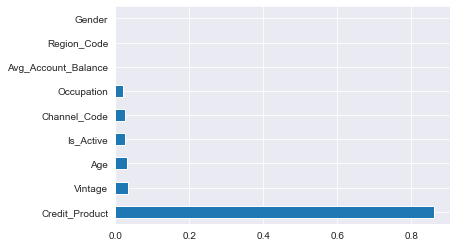

In [68]:
#Importance of features in the training dataset
feat_importances = pd.Series(gbcl.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [69]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['GradientBoost'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   
3       GradientBoost           85.46           85.47          86.57   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33  
3     62.66         72.27

In [70]:
print('Comparatively GradientBoost has better ROC AUC score than other techniques')

Comparatively GradientBoost has better ROC AUC score than other techniques


In [71]:
#Predit the test set for Is_Lead values
gbcl_preds = gbcl.predict_proba(test)[:, 1]
print('gbcl_preds :', gbcl_preds)
Is_Lead_values = gbcl_preds.round()
print('Is_Lead_values :', Is_Lead_values)

gbcl_preds : [0.07753062 0.8470857  0.05358672 ... 0.14432442 0.17688944 0.05358672]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [72]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': gbcl_preds })
Final_Submission.to_csv("GradientBoost.csv", index = False)

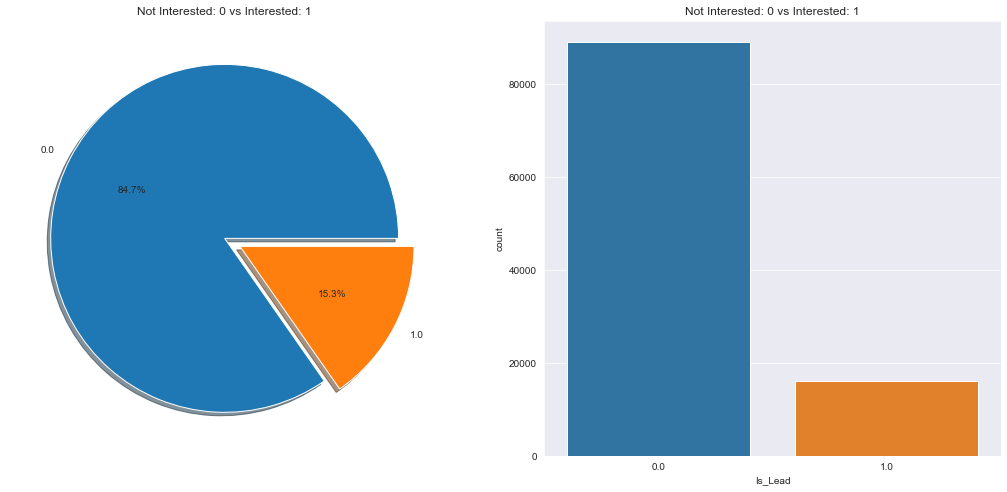

In [73]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values})
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()


# XGBoost Algorithm

In [76]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(x_train, y_train)

xgb_acc_train_sc = round(xgb.score(x_train, y_train)*100,2)
xgb_acc_valid_sc = round(xgb.score(x_valid, y_valid)*100,2)
print('accuracy score of XGBoost Train set is', xgb_acc_train_sc)
print('accuracy score of XGBoost Valid set is', xgb_acc_valid_sc)

[23:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy score of XGBoost Train set is 86.63
accuracy score of XGBoost Valid set is 85.76


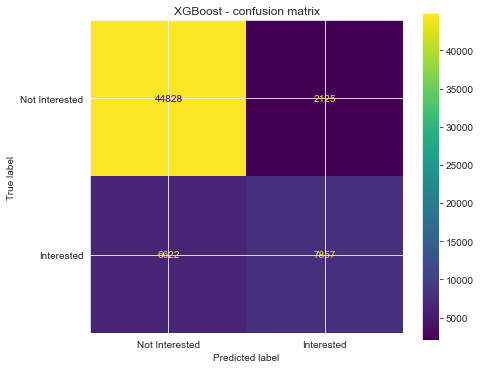

Accuracy Score Valid: 85.76
Accuracy Score Train: 86.63



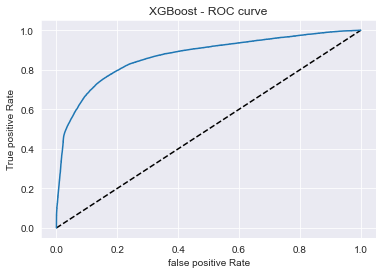

AUC SCore (ROC): 86.84 



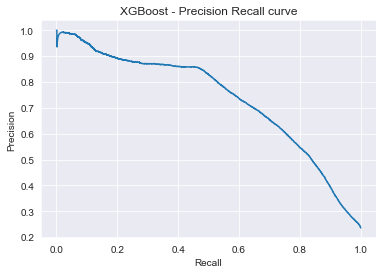

F1 score: 64.24 
AUC Score (PR): 73.63



In [77]:
y_pred = xgb.predict(x_valid)
y_pred_prob = xgb.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, xgb, y_pred, 'XGBoost')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'XGBoost')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'XGBoost')

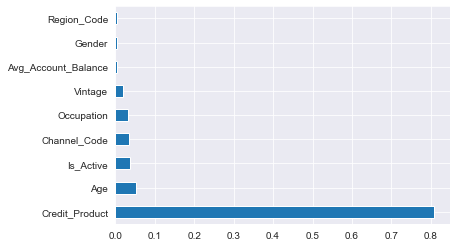

In [78]:
#Importance of features in the training dataset
feat_importances = pd.Series(xgb.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [79]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   
3       GradientBoost           85.46           85.47          86.57   
4             XGBoost           86.63           85.76          86.84   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33  
3     62.66         72.27  
4     64.24         73.63

In [80]:
print('Comparatively XGBoost has better ROC AUC score than other techniques')

Comparatively XGBoost has better ROC AUC score than other techniques


In [81]:
#Predit the test set for Is_Lead values
xgb_preds = xgb.predict_proba(test)[:, 1]
print('xgb_preds :', xgb_preds)
Is_Lead_values = xgb_preds.round()
print('Is_Lead_values :', Is_Lead_values)

xgb_preds : [0.04330848 0.85709935 0.05849144 ... 0.1871143  0.2154635  0.05487975]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [82]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': xgb_preds })
Final_Submission.to_csv("XGBoost.csv", index = False)

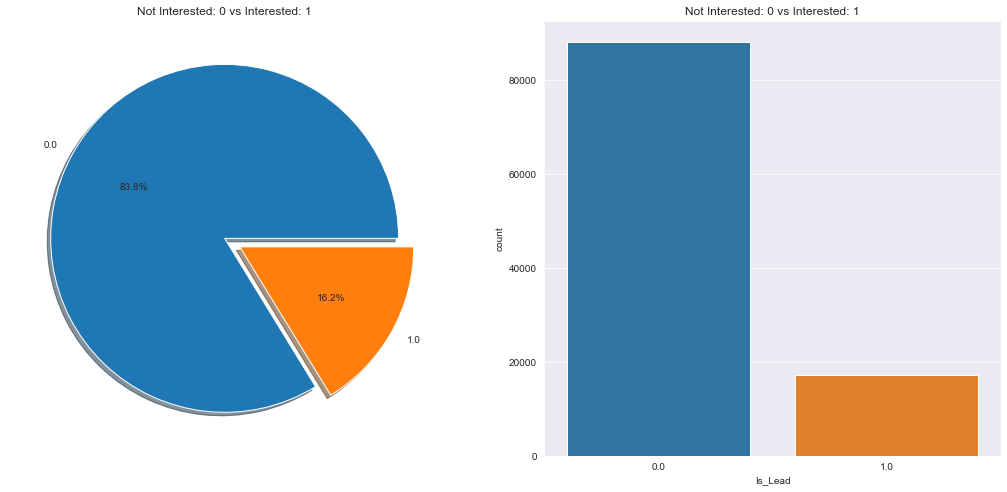

In [83]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values})
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()

# CatBoost Algorithm

In [84]:
cat_col=['Gender','Age', 'Occupation', 'Vintage', 'Channel_Code', 'Region_Code', 'Credit_Product', 'Is_Active']

In [85]:
cbcl = CatBoostClassifier()
cbcl = cbcl.fit(x_train, y_train,cat_features=cat_col,eval_set=(x_valid, y_valid),plot=True,early_stopping_rounds=30,verbose=100)

cbcl_acc_train_sc = round(cbcl.score(x_train, y_train)*100,2)
cbcl_acc_valid_sc = round(cbcl.score(x_valid, y_valid)*100,2)
print('accuracy score of CatBoost Train set is', cbcl_acc_train_sc)
print('accuracy score of CatBoost Valid set is', cbcl_acc_valid_sc)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.114945
0:	learn: 0.6121209	test: 0.6121234	best: 0.6121234 (0)	total: 556ms	remaining: 9m 15s
100:	learn: 0.3451193	test: 0.3474782	best: 0.3474689 (89)	total: 34.4s	remaining: 5m 5s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.3472514742
bestIteration = 163

Shrink model to first 164 iterations.
accuracy score of CatBoost Train set is 86.03
accuracy score of CatBoost Valid set is 85.94


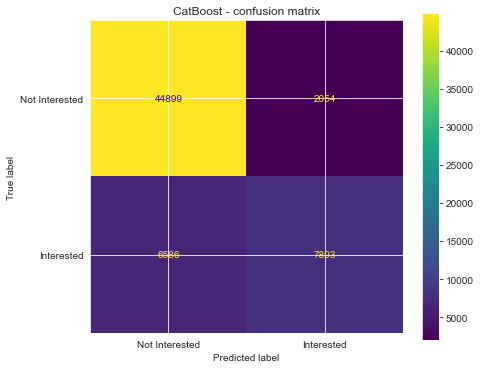

Accuracy Score Valid: 85.94
Accuracy Score Train: 86.03



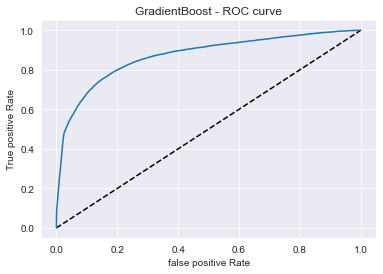

AUC SCore (ROC): 87.09 



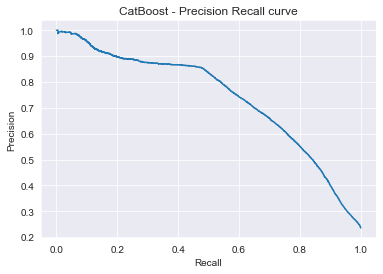

F1 score: 64.63 
AUC Score (PR): 74.13



In [86]:
y_pred = cbcl.predict(x_valid)
y_pred_prob = cbcl.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, cbcl, y_pred, 'CatBoost')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'GradientBoost')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'CatBoost')

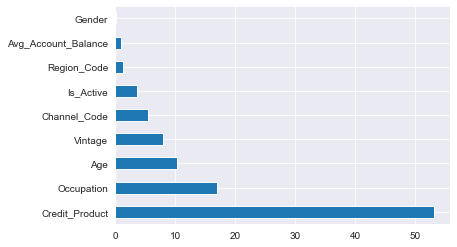

In [87]:
#Importance of features in the training dataset
feat_importances = pd.Series(cbcl.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [88]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['CatBoost'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   
3       GradientBoost           85.46           85.47          86.57   
4             XGBoost           86.63           85.76          86.84   
5            CatBoost           86.03           85.94          87.09   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33  
3     62.66         72.27  
4     64.24         73.63  
5     64.63         74.13

In [89]:
print('Comparatively CatBoost has better ROC AUC score than other techniques')

Comparatively CatBoost has better ROC AUC score than other techniques


In [90]:
#Predit the test set for Is_Lead values
cbcl_preds = cbcl.predict_proba(test)[:, 1]
print('cbcl_preds :', cbcl_preds)
Is_Lead_values = cbcl_preds.round()
print('Is_Lead_values :', Is_Lead_values)

cbcl_preds : [0.04434688 0.85815523 0.05169658 ... 0.11918474 0.1878136  0.05314616]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [91]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': cbcl_preds })
Final_Submission.to_csv("CatBoost.csv", index = False)

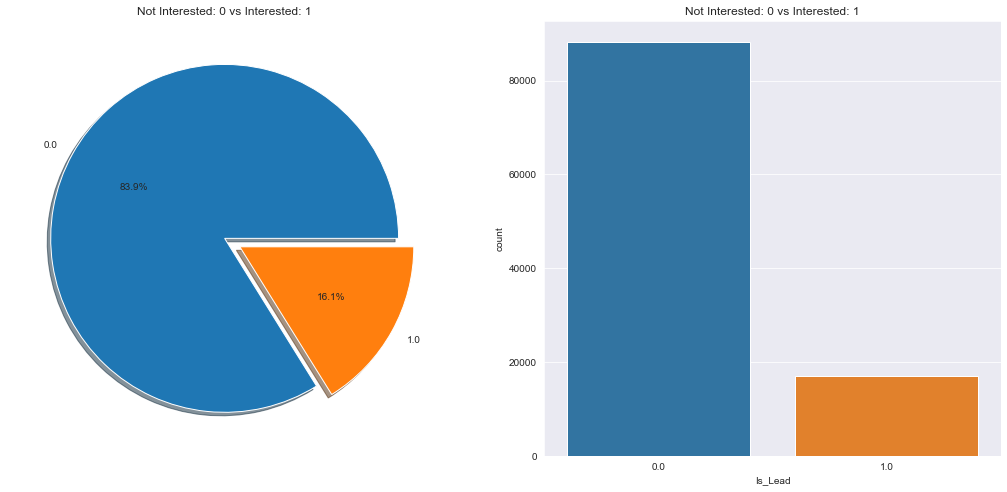

In [92]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values})
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()

# LightBoost Algorithm

In [93]:
lgbcl = LGBMClassifier()
lgbcl = lgbcl.fit(x_train, y_train)

lgbcl_acc_train_sc = round(lgbcl.score(x_train, y_train)*100,2)
lgbcl_acc_valid_sc = round(lgbcl.score(x_valid, y_valid)*100,2)
print('accuracy score of LightBoost Train set is', lgbcl_acc_train_sc)
print('accuracy score of LightBoost Valid set is', lgbcl_acc_valid_sc)

accuracy score of LightBoost Train set is 86.13
accuracy score of LightBoost Valid set is 85.91


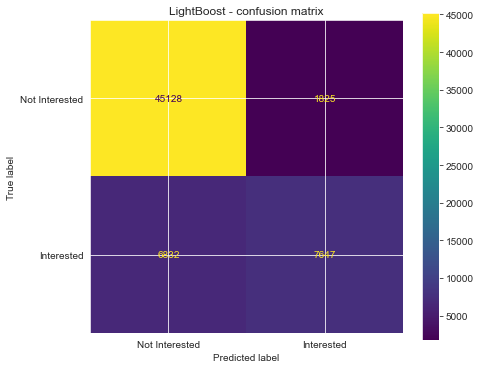

Accuracy Score Valid: 85.91
Accuracy Score Train: 86.13



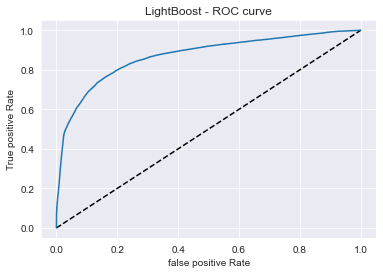

AUC SCore (ROC): 87.0 



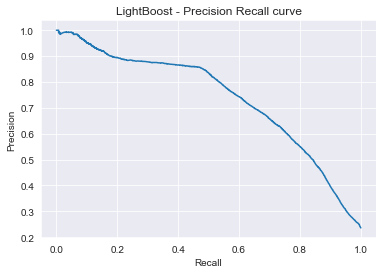

F1 score: 63.86 
AUC Score (PR): 74.03



In [94]:
y_pred = lgbcl.predict(x_valid)
y_pred_prob = lgbcl.predict_proba(x_valid)

confusion_matrix_plot(x_train,y_train,x_valid,y_valid, lgbcl, y_pred, 'LightBoost')
roc_curve_auc_score(x_valid,y_valid,y_pred_prob, 'LightBoost')
precision_recall_curve_and_scores(x_valid,y_valid,y_pred,y_pred_prob, 'LightBoost')

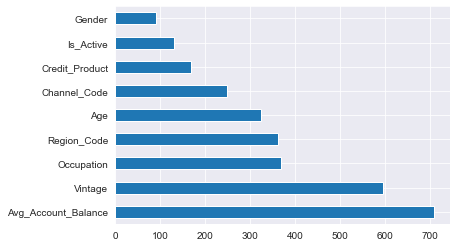

In [95]:
#Importance of features in the training dataset
feat_importances = pd.Series(lgbcl.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [96]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['LightBoost'], 'Train accuracy': [acc_train_sc],'Valid accuracy':[acc_valid_sc],'ROC AUC Score':[score],'F1 Score':[f1_score_result],'PR AUC_Score': [auc_score_result]})
resultsDf = pd.concat([resultsDf, tempResultsDf], ignore_index=True)
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   
3       GradientBoost           85.46           85.47          86.57   
4             XGBoost           86.63           85.76          86.84   
5            CatBoost           86.03           85.94          87.09   
6          LightBoost           86.13           85.91          87.00   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33  
3     62.66         72.27  
4     64.24         73.63  
5     64.63         74.13  
6     63.86         74.03

In [97]:
print('Comparatively CatBoost has better ROC AUC score than other techniques')

Comparatively CatBoost has better ROC AUC score than other techniques


In [98]:
#Predit the test set for Is_Lead values
lgbcl_preds = lgbcl.predict_proba(test)[:, 1]
print('lgbcl_preds :', lgbcl_preds)
Is_Lead_values = lgbcl_preds.round()
print('Is_Lead_values :', Is_Lead_values)

lgbcl_preds : [0.03695764 0.85305242 0.05374446 ... 0.13059548 0.19398302 0.05394053]
Is_Lead_values : [0. 1. 0. ... 0. 0. 0.]


In [99]:
Final_Submission = pd.DataFrame({ 'ID': ID, 'Is_Lead': lgbcl_preds })
Final_Submission.to_csv("LightBoost.csv", index = False)

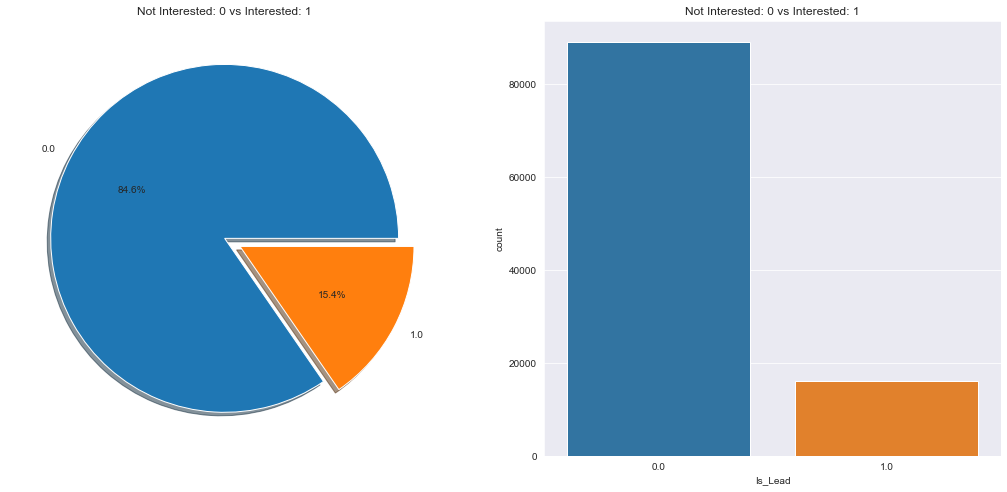

In [100]:
plot_Data = pd.DataFrame({ 'ID': ID, 'Is_Lead': Is_Lead_values})
f,ax=plt.subplots(1,2,figsize=(18,8))
plot_Data['Is_Lead'].round().value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Not Interested: 0 vs Interested: 1')
ax[0].set_ylabel('')
sns.countplot('Is_Lead',data=plot_Data,ax=ax[1])
ax[1].set_title('Not Interested: 0 vs Interested: 1')
plt.show()

# Conclusion

In [101]:
resultsDf

Method  Train accuracy  Valid accuracy  ROC AUC Score  \
0       Decision Tree           84.65           84.74          84.01   
1  Random Forest Tree           99.86           83.11          83.25   
2            AdaBoost           84.65           84.74          85.41   
3       GradientBoost           85.46           85.47          86.57   
4             XGBoost           86.63           85.76          86.84   
5            CatBoost           86.03           85.94          87.09   
6          LightBoost           86.13           85.91          87.00   

   F1 Score  PR AUC_Score  
0     56.95         70.24  
1     61.67         67.23  
2     56.95         69.33  
3     62.66         72.27  
4     64.24         73.63  
5     64.63         74.13  
6     63.86         74.03

In [103]:
print('From the above results table, we can conclude that CatBoost Algorithm has predicted us the most accurate values based on ROC_AUC_score')

From the above results table, we can conclude that CatBoost Algorithm has predicted us the most accurate values based on ROC_AUC_score


# **END**